## Проведение A-B теста

Пришло время проанализировать результаты эксперимента, который мы провели вместе с командой дата сайентистов. Эксперимент проходил  с 2022-01-28 по 2022-02-03 включительно. Для эксперимента были задействованы 0 и 1 группы.  

В 1 группе был использован новый алгоритм рекомендации постов, 0 группа использовалась в качестве контроля. 

Основная гипотеза заключается в том, что новый алгоритм в 1 группе приведет к увеличению CTR. 

**Задача** — проанализировать данные АB-теста.

1. Выбрать метод анализа и сравнить CTR в двух группах.
2. Провести контрольную проверку, что новый алгоритм не привел к тому, что сократилось число просмотров у пользователей. Типичная ситуация в АB-тестах — вырастили число лайков, но уменьшили число просмотров.
3. Написать рекомендацию, будем ли мы раскатывать новый алгоритм на всех новых пользователей.

In [1]:
import pandahouse as ph
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

sns.set(rc={'figure.figsize':(16,9)}, 
        style="whitegrid")

In [2]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': '*****',
    'user': '******',
    'database': 'simulator'
}

In [3]:
sql_query = """
SELECT user_id,
       exp_group,
       countIf(action='like') AS likes,
       countIf(action='view') AS views,
       likes / views AS ctr
FROM simulator_20220120.feed_actions
WHERE toDate(time) >= '2022-01-28'
      AND
      toDate(time) <= '2022-02-03'
      AND
      exp_group in (0, 1)
GROUP BY user_id,
         exp_group
"""

df = ph.read_clickhouse(sql_query, connection=connection) 

In [4]:
df

user_id  exp_group  likes  views       ctr
0        26117          1      5     21  0.238095
1       138232          1      5     29  0.172414
2        49204          1     10     62  0.161290
3        49286          1      7     19  0.368421
4       145957          1     54    129  0.418605
...        ...        ...    ...    ...       ...
25994     3681          0      6     28  0.214286
25995   110956          1     12     63  0.190476
25996   132567          1     18     66  0.272727
25997    30872          1     25     82  0.304878
25998    11718          0      7     37  0.189189

[25999 rows x 5 columns]

***Проведем проверку распределений CTR***

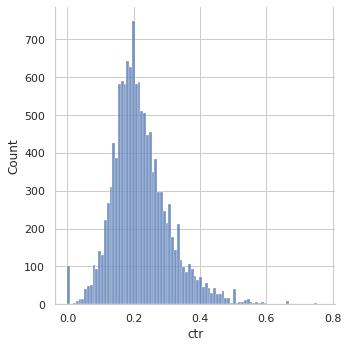

In [5]:
# Для контрольной группы

sns.displot(df[df.exp_group == 0].ctr, kde=False)

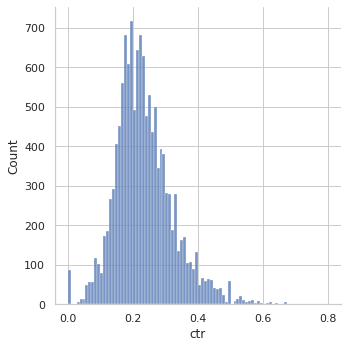

In [6]:
# Для тестовой группы

sns.displot(df[df.exp_group == 1].ctr, kde=False)

In [7]:
# Основные показатели контрольной группы (CTR)

df[df.exp_group == 0].ctr.describe()

count    12997.000000
mean         0.221955
std          0.087870
min          0.000000
25%          0.166667
50%          0.208333
75%          0.266667
max          0.769231
Name: ctr, dtype: float64

In [8]:
# Основные показатели тестовой группы (CTR)

df[df.exp_group == 1].ctr.describe()

count    13002.000000
mean         0.236486
std          0.090146
min          0.000000
25%          0.178082
50%          0.224138
75%          0.285714
max          0.800000
Name: ctr, dtype: float64

In [9]:
# Основные показатели контрольной группы (просмотры)

df[df.exp_group == 0].views.describe()

count    12997.000000
mean        61.297915
std         42.510039
min          1.000000
25%         29.000000
50%         51.000000
75%         83.000000
max        366.000000
Name: views, dtype: float64

In [10]:
# Основные показатели тестовой группы (просмотры)

df[df.exp_group == 1].views.describe()

count    13002.000000
mean        61.200508
std         42.124403
min          1.000000
25%         30.000000
50%         51.000000
75%         83.000000
max        362.000000
Name: views, dtype: float64

In [11]:
df[df.exp_group == 0].views.sum()

796689

In [12]:
df[df.exp_group == 1].views.sum()

795729

Конечно, на глаз определять - плохо, но даже так мы уже видим, что показатели CTR тестовой группы группы значительно выше. 

Просмотры в тестовой группе снизились, но на вид незначительно. 

**1. Проверка критерием Манна-Уитни**

Гипотезы:

**H0:** выборки статзначимо *не* отличаются.

**H1:** выборки статзначимо отличаются.

Для проверки гипотезы используем непараметрический критерий Манна-Уитни, т.к. в распредлении имеются выбросы.

In [13]:
stats.mannwhitneyu(df[df.exp_group == 0].ctr, df[df.exp_group == 1].ctr)

MannwhitneyuResult(statistic=75455843.5, pvalue=1.9101702958848542e-50)

In [14]:
stats.mannwhitneyu(df[df.exp_group == 0].views, df[df.exp_group == 1].views)

MannwhitneyuResult(statistic=84514942.0, pvalue=0.9717276363684261)

***Проверка*** значений ***CTR*** показала, что значение p-value значительно < 0.05, что позволяет нам отклонить нулевую гиппотезу, а значит ***выборки статзначимо отличаются***. 

***Проверка*** значений ***просмотров*** показала, что значение p-value значительно > 0.05, что значит ***выборки статзначимо не отличаются***. 

Пока выглядит всё так, что новый алгоритм работает отлично, но продолжим проверки.

**2. Проверка T-критерием Стьюдента**

Гипотезы:

**H0:** средние значения в выборках равны.

**H1:** средние значения в выборках *не* равны.

Несмотря на то, что данные имеют выбросы, мы можем также проверить гипотезу с помощью Т-критерия Стьюдента. Т.к. выборка имеет большое количество наблюдений.

In [15]:
stats.ttest_ind(df[df.exp_group == 0].ctr, df[df.exp_group == 1].ctr)

Ttest_indResult(statistic=-13.161104283251186, pvalue=1.9646203782402242e-39)

Значение p-value значительно < 0.05, что позволяет нам отклонить нулевую гиппотезу, а значит ***средние значения CTR выборок статзначимо отличаются***

In [16]:
stats.ttest_ind(df[df.exp_group == 0].views, df[df.exp_group == 1].views)

Ttest_indResult(statistic=0.1855745874228441, pvalue=0.8527798314430739)

Значение p-value значительно > 0.05, что не позволяет нам отклонить нулевую гиппотезу, а значит ***средние значения просмотров выборок статзначимо не отличаются***

### Проблема искажения метрики

Так как пользователи отличаются между собой по количеству просмотров, мы не можем до конца полагаться на параметр CTR. Он может быть искажен. Особенно для тех пользователей, которые имеют количество просмотров близкое к 0. 

Для решения этой проблемы есть 2 метода:

**1. Посчитаем сглаженный CTR для каждого пользователя и проведем Т-тест.**

In [17]:
# Функция для потсчета сглаженного CTR

def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

In [18]:
# Разбиваю исходный датафрейм на 2 (контрольный и тестовый)

df_control = df[df.exp_group == 0]
df_test = df[df.exp_group == 1]

In [19]:
# Делаю подсчет глобального (общего) CTR для каждой группы

global_ctr_control = df_control.likes.sum() / df_control.views.sum()
global_ctr_test = df_test.likes.sum() / df_test.views.sum()

In [20]:
# Добавляю колонку со сглаженным CTR в контрольную группу

df_control['smothed_ctr'] = df_control.apply(lambda x: 
                                             get_smothed_ctr(x['likes'], 
                                                             x['views'], 
                                                             global_ctr_control, 
                                                             5), axis=1)
df_control.sort_values('ctr')

user_id  exp_group  likes  views       ctr  smothed_ctr
16144    26842          0      0     13  0.000000     0.059195
4246    129662          0      0     11  0.000000     0.066595
9464     21767          0      0      6  0.000000     0.096865
16444     9484          0      0     10  0.000000     0.071034
4359     27761          0      0      3  0.000000     0.133190
...        ...        ...    ...    ...       ...          ...
2868    114276          0      6      8  0.750000     0.543501
3198     48952          0     15     20  0.750000     0.642621
22571    13996          0     12     16  0.750000     0.622167
8705     11778          0      6      8  0.750000     0.543501
16441    17197          0     10     13  0.769231     0.614751

[12997 rows x 6 columns]

In [21]:
# Добавляю колонку со сглаженным CTR в тестовую группу

df_test['smothed_ctr'] = df_test.apply(lambda x: 
                                             get_smothed_ctr(x['likes'], 
                                                             x['views'], 
                                                             global_ctr_test, 
                                                             5), axis=1)
df_test.sort_values('ctr')

user_id  exp_group  likes  views       ctr  smothed_ctr
7906    133728          1      0     10  0.000000     0.076634
15681    53267          1      0     12  0.000000     0.067618
16563   128152          1      0     16  0.000000     0.054739
21802   113079          1      0     11  0.000000     0.071844
15669    12474          1      0     12  0.000000     0.067618
...        ...        ...    ...    ...       ...          ...
13134    24240          1      5      7  0.714286     0.512459
21845     4160          1      9     12  0.750000     0.597030
13274   121188          1      7      9  0.777778     0.582108
13286   110957          1      7      9  0.777778     0.582108
13754    11546          1      8     10  0.800000     0.609967

[13002 rows x 6 columns]

В зависимости от числа просмотра, уровень CTR пользователей сместился ближе к глобальному CTR. 

Т.е. если у пользователя мало просмотров, но высокий CTR, то этот метод снижает CTR пользователя. И наоборот, если мало просмотров и низкий CTR, то повышает его. А у пользователей, которые имеют большое число просмотров параметр CTR почти не изменился. 

Теперь посмотрим на распределение значений сглаженного CTR:

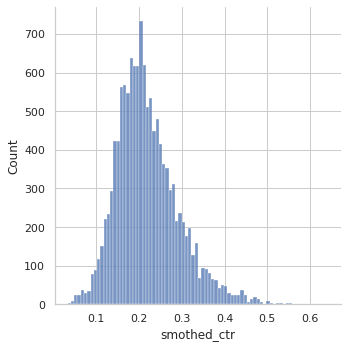

In [22]:
sns.displot(df_control.smothed_ctr, kde=False)

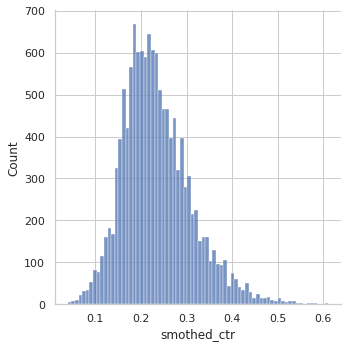

In [23]:
sns.displot(df_test.smothed_ctr, kde=False)

Всё это проводилось для того, чтобы более уверенно применить Т-критерий Стьюдента для проверки средних значений распределений. 

Также применение т-теста позволит нам в будущем использовать параметрические идеи для определения размера выборки для проведения эксперимента

In [24]:
stats.ttest_ind(df_control.smothed_ctr, df_test.smothed_ctr)

Ttest_indResult(statistic=-16.361154235385495, pvalue=7.217598310300211e-60)

P-value сравнения сглаженного CTR контрольный и тестовой групп показывает, что их ***средние значения значимо отличаются.***

**2. Уход от поюзерного сравнения к оценке глобального CTR методом Bootstrap**

Суть метода заключается в том, что мы воспринимаем нашу выборку как модель генеральной совокупности, а затем многократно вытягиваем подвыборки с повторением и считаем для каждой подвыборки общий CTR. Таким образом, получаем распредление CTR значений групп.

In [25]:
# Функция для оценки общего CTR методом Bootstrap.
# На выходе получаем распределение значений CTR подвыборок и доверительный интервал

def get_global_ctr(ctr_data, n_samples=10000):
    global_ctr_data = []
    for i in range(n_samples):
        resample_data = ctr_data.sample(frac=0.5, replace=True)
        global_ctr = resample_data.likes.sum() / resample_data.views.sum()
        global_ctr_data.append(global_ctr)
        
    sns.displot(global_ctr_data)
    
    return [pd.Series(global_ctr_data).quantile(0.05),
            pd.Series(global_ctr_data).mean(),
            pd.Series(global_ctr_data).quantile(0.95)]

[0.21154642089142123, 0.2131083310055776, 0.21464843551344642]

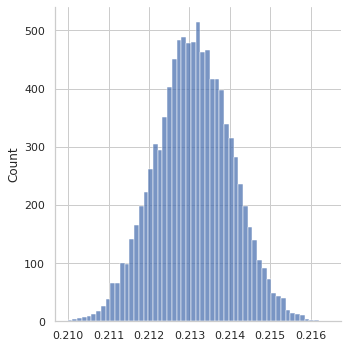

In [26]:
get_global_ctr(df_control)

[0.22832024086655892, 0.22991284839585005, 0.23153363668615842]

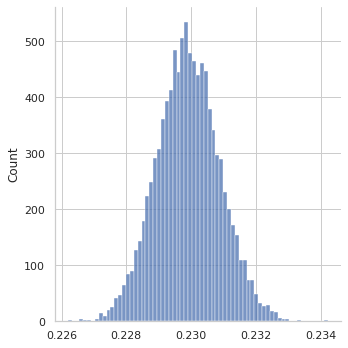

In [27]:
get_global_ctr(df_test)

Т.к. доверительные интервалы не пересекаются и в них не входит 0, то мы можем отклонить нулевую гипотезу. Значит ***значения глобальных CTR в группах статзначимо различаются.***

## Вывод

1. Все тесты (поюзерное сравнение CTR с помощью критерия Манна-Уитни и Т-критерия Стьюдента, а также сравнение сглаженного CTR и оценка глобального CTR) показали, что CTR тестовой группы статзначимо выше контрольной группы.

2. Число просмотров в тестовой группе снизилось, но падение не является статистически значимым. 

***Рекомендую раскатывать новый алгоритм на всех новых пользователей***